## We have consistently observed through our data and customer meetings, as well as testing our product, that a stale model performs poorly compared to a recently trained one. This trend holds true without exception. The change in yield spreads and curves, as evidenced by our analysis, supports this intuitively.

In [1]:
# Author: Gil
# Date: 2022-01-03
# Last Modified by: Gil
# Last Modified time: 2023-02-02

# imports:

import gcsfs
import warnings
import pandas as pd
import pickle
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np  
import torch
import sklearn
import ficc.utils.globals as globals
import seaborn as sns
import math
import tensorflow as tf
from datetime import timedelta ,datetime

from google.cloud import storage
from google.cloud import bigquery
from tensorflow import keras
from IPython.display import display, HTML
from matplotlib.colors import to_rgb, to_rgba

from ficc.utils.yield_curve import get_ficc_ycl,yield_curve_level
from ficc.utils.gcp_storage_functions import download_data
from ficc.utils.auxiliary_variables import PREDICTORS, IDENTIFIERS, CATEGORICAL_FEATURES, NON_CAT_FEATURES, BINARY
from ficc.models import get_model_instance
from ficc.data.process_data import process_data
from ficc.pricing.auxiliary_functions import transform_reference_data
from ficc.pricing.price import compute_price
from calendars import get_day_before

from ficc.utils.diff_in_days import diff_in_days_two_dates
from ficc.utils.auxiliary_variables import NUM_OF_DAYS_IN_YEAR
from tensorflow.keras.models import Model

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(12,9)})

# Globals:

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/gil/git/ficc/creds.json"

calc_date_cat_dict = {0:'next_call_date',
    1:'par_call_date',
    2:'maturity_date',
    3:'refund_date'}

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Testing the latest attention model:

In [2]:

yield_spread_model = keras.models.load_model('/Users/gil/git/ficc/notebooks/measures_accuracy/model_dec_30')

2023-02-02 13:11:51.037888: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# CATEGORICAL_FEATURES.remove('ttypes')
# PREDICTORS.remove('ttypes')

In [4]:
# Functions:

def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        print(f)
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def get_spread(df):

    '''
    This function takes a dataframe, encodes the features, and returns yield spread estimates.
    NB: This is only used by get_prediction_from_individual_pricing.  In order to be DRY, get_BB11_table and get_ytw_curve
    should also use this function. 
    '''
    
    inputs = create_input(df)
    global yield_spread_model
    preds = yield_spread_model.predict(inputs)
    preds = preds.reshape(len(preds))
    return preds

# plot points with transparency depending on size of trade
def drawpoints(preds, target, test_dataframe):
    # >> Only draw Dealer-Dealer trades <<
    r, g, b = to_rgb('purple')
    keep = (10**test_dataframe.quantity > threshold)  # save time by not plotting points that would be invisible
    w = np.minimum( np.array(10**test_dataframe.quantity[keep]), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    plt.scatter(preds[keep], target[keep], s=5, c=color)

def category_to_calc_date(row):
    if row.ficc_calc_date_cat == 0:
        if not row.is_callable and not row.is_called:
            return row['maturity_date']
        elif not row.is_callable and row.is_called:  
            return row.refund_date
        else:  
            return row['next_call_date']
    elif row.ficc_calc_date_cat == 1:
        return row['par_call_date']
    elif row.ficc_calc_date_cat == 2:
        return row['maturity_date']
    elif row.ficc_calc_date_cat == 3:
        if not row.is_called:
            return row.maturity_date
        else:
            return row.refund_date
    else:
        print(row.ficc_calc_date_cat)
        raise ValueError("Calculation date not found")

def get_trade_price(trade):
    # compute price does not need to return the calc_date, if we are using the calc_date model: 
    final, _ = compute_price(trade, trade.ficc_ytw)
    return final

def target_trade_processing_for_attention(row):
    trade_mapping = {'D':[0,0], 'S':[0,1], 'P':[1,0]}
    target_trade_features = []
    target_trade_features.append(row['quantity'])
    target_trade_features = target_trade_features + trade_mapping[row['trade_type']]
    return np.tile(target_trade_features, (5,1))

The test data below should start after the date for which the model is trained.

In [5]:
from google.cloud import bigquery
from ficc.data.process_data import process_data

SEQUENCE_LENGTH = 5
NUM_FEATURES = 6

DATA_QUERY = '''
  SELECT
    * except(most_recent_event)
  FROM
    `eng-reactor-287421.auxiliary_views.materialized_trade_history`
  WHERE
    trade_date >= '2023-01-19'
--    AND trade_date < '2022-11-06'
    AND msrb_valid_to_date > current_date -- condition to remove cancelled trades
  ORDER BY
    trade_datetime desc
'''

bq_client = bigquery.Client()

# trade_data = process_data(DATA_QUERY, 
#                 bq_client,
#                 SEQUENCE_LENGTH,
#                 NUM_FEATURES,
#                 'data.pkl',
#                 'FICC_NEW',
#                 estimate_calc_date=False,
#                 remove_short_maturity=False,
#                 remove_non_transaction_based=False,
#                 remove_trade_type = [],
#                 trade_history_delay = 0,
#                 min_trades_in_history = 0,
#                 process_ratings=False,
#                 treasury_spread = True,
#                 add_previous_treasury_rate=True,
#                 add_previous_treasury_difference=True,
#                 use_last_duration=False,
#                 add_flags=False)

# trade_data.to_pickle("processed_data.pkl")

trade_data = pd.read_pickle("processed_data.pkl")

#trade_data = trade_data[:1000]

In [6]:
#for the attention model
#trade_data['target_attention_features'] = trade_data.apply(target_trade_processing_for_attention, axis = 1)

if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

Save time with smaller dataset: 

In [7]:
# why do I need to this twice? Investigate the scope loss
# fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with open('/Users/gil/git/ficc/notebooks/measures_accuracy/encoders_2023-01-25-19-11.pkl','rb') as f:
    encoders = pickle.load(f)
    
print(encoders)

{'rating': LabelEncoder(), 'incorporated_state_code': LabelEncoder(), 'trade_type': LabelEncoder(), 'purpose_class': LabelEncoder()}


In [8]:
data = trade_data

In [9]:
data = data[data.trade_date >= "2023-01-01"]

In [10]:
len(data)

729881

In [11]:
data.loc[data.sp_stand_alone.isna(), 'sp_stand_alone'] = 'NR'
data.rating = data.rating.astype('str')
data.sp_stand_alone = data.sp_stand_alone.astype('str')
data.loc[(data.sp_stand_alone != 'NR'),'rating'] = data[(data.sp_stand_alone != 'NR')]['sp_stand_alone'].loc[:]

In [12]:
data = data[data.incorporated_state_code != 'PR']

df = data

if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')

predicted_spreads = get_spread(df[PREDICTORS])
df = df.copy()
df['ficc_spreads'] = predicted_spreads #new_ys

rating
incorporated_state_code
trade_type
purpose_class


In [13]:
df.trade_date.value_counts()

2023-01-04    45601
2023-01-11    39623
2023-01-09    39268
2023-01-23    39013
2023-01-05    38742
2023-01-10    38738
2023-01-03    38628
2023-01-18    38506
2023-01-25    38222
2023-01-12    37980
2023-01-31    37798
2023-01-19    37732
2023-01-20    36904
2023-01-26    36869
2023-01-06    35396
2023-01-30    34618
2023-01-17    34555
2023-01-13    30491
2023-01-27    30267
2023-01-24    20512
Name: trade_date, dtype: int64

In [14]:
df['error'] =  np.abs(df.yield_spread - df.ficc_spreads)

### Analyze MAE on various values for categorical features such as purpose_class and use_of_proceeds (and others...). 

In [15]:
# for c in ['orig_principal_amount', 'purpose_sub_class','federal_tax_status','state_tax_status','use_of_proceeds','muni_security_type','muni_issue_type','capital_type','other_enhancement_type']:
#     print(f"{c}:")
#     print(df.groupby([c])['error'].agg(["mean","count"]).reset_index().sort_values('mean'))

### Accuracy

In [16]:
from scipy import stats

def mkeasy(df):
    df = df[df.trade_type != "P"]
    df = df[df.quantity > np.log10(3e5 - 1)]
    df = df[df.last_size > np.log10(3e5 - 1)]
    # df = df[df.federal_tax_status != 3]
    df = df[~df.par_issue]
    df = df[df.mindays > 180]
    df = df[df.trade_datetime != pd.to_datetime("2022-11-29T16:00:14")]
    return df.copy()

def dailyskew(df, feat='coupon', val='all', metric='error', month=0):
    if month > 0: df = df[df.month == month]
    z = np.nan_to_num( stats.zscore(df[metric], nan_policy='omit'), 99)
    df = df[np.abs(z) < 9]
    other = df[df[feat] != val]
    otherdaily = other.groupby('trade_date')[metric]
    if val == 'all':
        skew = otherdaily.mean()
        delta = 2 * otherdaily.std() / np.sqrt( otherdaily.count() )
    else:
        these = df[df[feat] == val]
        thesedaily = these.groupby('trade_date')[metric]
        skew = thesedaily.mean() - otherdaily.mean()
        delta = otherdaily.std() / np.sqrt( otherdaily.count() ) + thesedaily.std() / np.sqrt( thesedaily.count() )
    avg = skew.mean()
    print( f"mean {avg:5.2f} +/- {skew.std():4.2f}  autocorr {skew.autocorr():4.2f}" )
    plt.figure(figsize=(12,4))
    plt.errorbar(x=skew.index, y=skew, yerr=delta, fmt='bo')

mean 10.79 +/- 0.49  autocorr 0.65


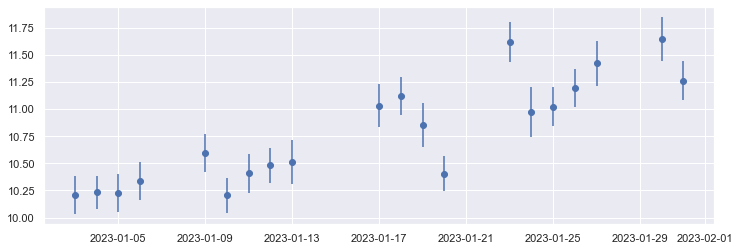

In [17]:
dailyskew(df)

In [18]:

#df = df[(df.trade_type == 'D') & (df.quantity >= np.log10(500000))]

daily_maes = []
dates = []
for d in [d for d in pd.date_range(start="01/01/2023",end="02/01/2023",freq='D')]:
    next_day = df[df.trade_date == d].copy()
    error = next_day.yield_spread - next_day.ficc_spreads
    MAE = np.mean(np.abs(error))
    daily_maes.append(MAE)
    dates.append(d)
    if not math.isnan(MAE):
        print(f"MAE for {d}: {MAE}")

rated = df[(df.rating != 'MR') & (df.rating != 'NR')].copy()
error = rated.yield_spread - rated.ficc_spreads
MAE = np.mean(np.abs(error))
print(f"\nAll Rated YS MAE: {round(MAE,3)}")

not_rated = df[(df.rating == 'MR')].copy()
error = not_rated.yield_spread - not_rated.ficc_spreads
MAE = np.mean(np.abs(error))
print(f"\nMissing Rating only YS MAE: {round(MAE,3)}")

not_rated = df[(df.rating == 'MR') | (df.rating == 'NR')].copy()
error = not_rated.yield_spread - not_rated.ficc_spreads
MAE = np.mean(np.abs(error))
print(f"\nAll Not Rated, MR & NRs YS MAE: {round(MAE,3)}")

error = df.yield_spread - df.ficc_spreads
MAE = np.mean(np.abs(error))
print(f"\nAll Trades Yield Spread Preds MAE: {round(MAE,3)}")

dd_true_mid_df = df[(df.trade_type == 'D') & (df.quantity >= np.log10(500000))] #& (df.days_to_call >= np.log10(365))]

error = dd_true_mid_df.yield_spread - dd_true_mid_df.ficc_spreads
MAE = np.mean(np.abs(error))
print(f"\nTrue-Mid DD Yield Spread Preds MAE: {round(MAE,3)}")


MAE for 2023-01-03 00:00:00: 10.32173955051333
MAE for 2023-01-04 00:00:00: 10.637278914068842
MAE for 2023-01-05 00:00:00: 13.217061708617411
MAE for 2023-01-06 00:00:00: 11.206348379940344
MAE for 2023-01-09 00:00:00: 12.975303874970946
MAE for 2023-01-10 00:00:00: 10.798458035374267
MAE for 2023-01-11 00:00:00: 10.822657115399563
MAE for 2023-01-12 00:00:00: 10.616492396070411
MAE for 2023-01-13 00:00:00: 10.622158362199578
MAE for 2023-01-17 00:00:00: 11.221743811423112
MAE for 2023-01-18 00:00:00: 11.396620354480426
MAE for 2023-01-19 00:00:00: 10.992778673269179
MAE for 2023-01-20 00:00:00: 10.548601683237655
MAE for 2023-01-23 00:00:00: 11.752062298138512
MAE for 2023-01-24 00:00:00: 10.97053817470847
MAE for 2023-01-25 00:00:00: 11.417610446684971
MAE for 2023-01-26 00:00:00: 13.143339217695175
MAE for 2023-01-27 00:00:00: 11.59327721673793
MAE for 2023-01-30 00:00:00: 11.79915627140228
MAE for 2023-01-31 00:00:00: 11.276475675950856

All Rated YS MAE: 11.31

Missing Rating onl

For the calc_date model, we need to make sure it is trained on a period that ends before the eval set in this notebook. And calculate the accuracy here too. 

In [19]:
def get_calc_date(row):
    if row.is_called:
        return row.refund_date
    elif row.is_called == False and row.is_callable is False:
        return row.maturity_date
    else:
        cat = row.last_calc_day_cat
        if cat == 0:
            return row.next_call_date
        elif cat == 1:
            return row.par_call_date
        elif cat == 2:
            return row.maturity_date
        else:
            return row.refund_date
        
def assign(calc_date, which, date):
    calc_date[which] = date[which]

def fast_calc_date(df):
    calc_date = df.par_call_date
    assign(calc_date, df.last_calc_day_cat == 0,                 df.next_call_date)
    assign(calc_date, df.ytw > 100 * df.coupon,                  df.maturity_date)
    assign(calc_date, df.deferred & (df.last_calc_day_cat == 0), df.next_call_date)
    assign(calc_date, ~df.is_callable,                           df.maturity_date)
    assign(calc_date, df.is_called,                              df.refund_date)
    return calc_date

def alt_calc_date(row):
    if row.is_called:
        return row.refund_date
    elif not row.is_callable:
        return row.maturity_date   
    elif (row.coupon == 0) and (row.last_calc_day_cat == 0):
        return row.next_call_date
    elif (row.ytw > 100 * row.coupon):
        return row.maturity_date 
    elif row.last_calc_day_cat == 0:
        return row.next_call_date
    else:                
        return row.par_call_date

def get_yield_for_last_duration(row):
    if row['last_calc_date'] is None or row['last_trade_date'] is None:
        return None
    # temp_date = get_day_before(row['trade_date'])
    duration =  diff_in_days_two_dates(row['last_calc_date'],row['last_trade_date'])/NUM_OF_DAYS_IN_YEAR
    ycl = yield_curve_level(duration, row['trade_date'], nelson_params, scalar_params, shape_parameter)/100
    return ycl

def sqltodf(sql, bq_client):
    bqr = bq_client.query(sql).result()
    return bqr.to_dataframe()

Beginning of calc date model investigation:
(Remove) The below is a debug cell to better understand when the labels are wrong

In [20]:
nelson_params = sqltodf("select * from `eng-reactor-287421.yield_curves_v2.nelson_siegel_coef_daily` order by date desc", bq_client)
nelson_params.set_index("date", drop=True, inplace=True)
nelson_params = nelson_params[~nelson_params.index.duplicated(keep='first')]

scalar_params = sqltodf("select * from`eng-reactor-287421.yield_curves_v2.standardscaler_parameters_daily` order by date desc", bq_client)
scalar_params.set_index("date", drop=True, inplace=True)
scalar_params = scalar_params[~scalar_params.index.duplicated(keep='first')]

shape_parameter  = sqltodf("SELECT *  FROM `eng-reactor-287421.yield_curves_v2.shape_parameters` order by Date desc", bq_client)
shape_parameter.set_index("Date", drop=True, inplace=True)
shape_parameter = shape_parameter[~shape_parameter.index.duplicated(keep='first')]

In [21]:
df['last_trade_date'] = df['last_trade_datetime'].dt.date
df['new_ficc_ycl'] = df[['last_calc_date','last_settlement_date','trade_date','last_trade_date']].parallel_apply(get_yield_for_last_duration, axis=1)

df['ytw'] = df.new_ficc_ycl + df.ficc_spreads #new_ys
df["calc_date_label"] = df.calc_date

# df['calc_date'] = df.apply(get_calc_date,axis=1) 
#df.ficc_calc_date_cat.map(calc_date_cat_dict).value_counts()

Process ForkPoolWorker-14:
Process ForkPoolWorker-7:
Process ForkPoolWorker-16:
Process ForkPoolWorker-13:
Process ForkPoolWorker-8:
Process ForkPoolWorker-3:
Process ForkPoolWorker-5:
Process ForkPoolWorker-15:
Process ForkPoolWorker-10:
Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-17:
Process ForkPoolWorker-9:
Process ForkPoolWorker-4:
Process ForkPoolWorker-12:
Process ForkPoolWorker-11:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result 

  File "/Users/gil/base/lib/python3.9/site-packages/ficc/utils/nelson_siegel_model.py", line 129, in yield_curve_level
    nelson_siegel_daily_coef, scaler_daily_parameters, shape_param = load_model_parameters(target_date,
  File "/Users/gil/base/lib/python3.9/site-packages/ficc/utils/nelson_siegel_model.py", line 50, in load_model_parameters
    scalar_coeff = scalar_params.iloc[scalar_params.index.get_loc(target_date, method='backfill')].values
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3825, in get_loc
    indexer = self.get_indexer([key], method=method, tolerance=tolerance)
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3967, in get_indexer
    return this._get_indexer(
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3984, in _get_indexer
    indexer = self._get_fill_indexer(target, method, limit, tolerance)
  File "/Users/gil/base/lib/python3.9/site-packages/p

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/apply.py", line 868, in apply_standard
    results, res_index = self.apply_series_generator()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/frame.py", line 9558, in apply
    return op.apply().__finalize__(self, method="apply")
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in 

KeyboardInterrupt: 

  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/frame.py", line 9558, in apply
    return op.apply().__finalize__(self, method="apply")
  File "/Users/gil/base/lib/python3.9/site-packages/pandarallel/pandarallel.py", line 64, in global_worker
    return _func(x)
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/frame.py", line 9558, in apply
    return op.apply().__finalize__(self, method="apply")
  File "/Users/gil/base/lib/python3.9/site-packages/pandarallel/pandarallel.py", line 64, in global_worker
    return _func(x)
  File "/Users/gil/base/lib/python3.9/site-packages/ficc/utils/nelson_siegel_model.py", line 50, in load_model_parameters
    scalar_coeff = scalar_params.iloc[scalar_params.index.get_loc(target_date, method='backfill')].values
  File "/Libra

  File "/var/folders/4p/6gk1pj4j1439gxdnw_vb8prw0000gn/T/ipykernel_99399/2647394404.py", line 48, in get_yield_for_last_duration
    ycl = yield_curve_level(duration, row['trade_date'], nelson_params, scalar_params, shape_parameter)/100
Traceback (most recent call last):
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/apply.py", line 741, in apply
    return self.apply_standard()
  File "/Users/gil/base/lib/python3.9/site-packages/db_dtypes/__init__.py", line 292, in astype
    return super().astype(dtype, copy=copy)
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3965, in get_indexer
    this = self.astype(dtype, copy=False)
  File "/Users/gil/base/lib/python3.9/site-packages/pandarallel/pandarallel.py", line 140, in wrapper
    result = function(
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/apply.py", line 868, in apply_standard
    results, res_index = self.apply_series_generator()
  File "/Users/gil/base/lib/

  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/apply.py", line 868, in apply_standard
    results, res_index = self.apply_series_generator()
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3965, in get_indexer
    this = self.astype(dtype, copy=False)
  File "/Users/gil/base/lib/python3.9/site-packages/ficc/utils/nelson_siegel_model.py", line 129, in yield_curve_level
    nelson_siegel_daily_coef, scaler_daily_parameters, shape_param = load_model_parameters(target_date,
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3967, in get_indexer
    return this._get_indexer(
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/Users/gil/base/lib/python3.9/site-packages/ficc/utils/nelson_siegel_model.py", line 129, in yield_curve_level
    nelson_siegel_daily_coef, 

  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/frame.py", line 9558, in apply
    return op.apply().__finalize__(self, method="apply")
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 1095, in astype
    new_values = values.astype(dtype, copy=copy)
  File "/Users/gil/base/lib/python3.9/site-packages/ficc/utils/nelson_siegel_model.py", line 49, in load_model_parameters
    nelson_coeff = nelson_params.iloc[nelson_params.index.get_loc(target_date, method='backfill')].values
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/arrays/base.py", line 608, in astype
    return np.array(self, dtype=dtype, copy=copy)
  File "/Users/gil/base/lib/python3.9/site-packages/db_dtypes/__init__.py", line 292, in astype
    return super().astype(dtype, copy=copy)
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/arrays/base.py", line 423, in __iter__
    yield self[i]
  File "/Users/gil/base/lib/python3.9/site-packages/pand

  File "/Users/gil/base/lib/python3.9/site-packages/ficc/utils/nelson_siegel_model.py", line 50, in load_model_parameters
    scalar_coeff = scalar_params.iloc[scalar_params.index.get_loc(target_date, method='backfill')].values
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/arrays/base.py", line 608, in astype
    return np.array(self, dtype=dtype, copy=copy)
KeyboardInterrupt
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/arrays/base.py", line 423, in __iter__
    yield self[i]
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3825, in get_loc
    indexer = self.get_indexer([key], method=method, tolerance=tolerance)
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/arrays/base.py", line 423, in __iter__
    yield self[i]
  File "/Users/gil/base/lib/python3.9/site-packages/pandas/core/arrays/_mixins.py", line 291, in __getitem__
  

In [ ]:
df['calc_date'] = fast_calc_date(df)

# df['calc_date'] = df.apply(alt_calc_date,axis=1)  

# df['calc_date'] = df['calc_date'].dt.date

In [ ]:
# df['calc_date'] = df.apply(get_calc_date,axis=1) 
# df['calc_date'] = df['calc_date'].dt.date

In [ ]:
print(f"accuracy of calc_date function - values we got right: {len(df[df.calc_date == df.calc_date_label])/len(df)}")
print(len(df))
#df = df[df.calc_date != df.calc_date_label]

In [ ]:
# this is the old calc_date func: 
df['calc_date'] = df.apply(get_calc_date,axis=1) 
df['calc_date'] = df['calc_date'].dt.date
print(f"accuracy of calc_date function - values we got right: {len(df[df.calc_date == df.calc_date_label])/len(df)}")
print(len(df))

End of calc_date model investigation - remove all NaTs: 

Using ficc YCL (not MMD):

In [ ]:
df.trade_date = df.trade_date.dt.date
df['msrb_price'] = df.dollar_price.copy()

In [ ]:
bq_client = bigquery.Client()
temp = df[['trade_date','calc_date']].apply(get_ficc_ycl,client=bq_client ,axis=1)
try:
    df[['ficc_ycl','ficc_ycl_3_month','ficc_ycl_1_month']] = pd.DataFrame(temp.tolist(), index=df.index)
except Exception as ex:
    df['ficc_ycl'] = pd.DataFrame(temp.tolist(), index=df.index)
# df['ficc_ycl'] = df.apply(get_ficc_ycl, axis=1, client=bq_client)   
df['ficc_ytw'] = (df.ficc_ycl + df.ficc_spreads)/100

In [ ]:
# Get price estimation:
transform_reference_data(df)
df['price_calc_from_yield'] = df.apply(lambda x: get_trade_price(x), axis=1)

In [ ]:
analysis_df = df # df[(df.trade_type == 'D') & (df.quantity >= np.log10(500000))].copy()  

In [ ]:
# trade size plot threshold:
threshold = 1e5

from importlib import reload
plt=reload(plt)

plt.close()
fig = plt.figure()
fig.suptitle('Yield Spread Accuracy', fontsize=15)
drawpoints(analysis_df.ficc_spreads, analysis_df.yield_spread, analysis_df)
plt.xlabel('predicted_spreads', fontsize=15)
plt.ylabel('actual yield spread', fontsize=15)

In [ ]:
fig = plt.figure()
fig.suptitle('YTW Accuracy', fontsize=15)
drawpoints(analysis_df.ficc_ytw, analysis_df['yield'], analysis_df)
plt.xlabel('predicted ytw', fontsize=15)
plt.ylabel('actual ytw', fontsize=15)

error = analysis_df['yield'] - analysis_df.ficc_ytw
MAE = np.mean(np.abs(error))
print(f"YTW MAE: {round(MAE,3)}")

In [ ]:
fig = plt.figure()
fig.suptitle('Price Accuracy', fontsize=15)
drawpoints(analysis_df.price_calc_from_yield, analysis_df.dollar_price, analysis_df)
plt.xlabel('predicted price', fontsize=15)
plt.ylabel('actual price', fontsize=15)

error = analysis_df.dollar_price - analysis_df.price_calc_from_yield
MAE = np.mean(np.abs(error))
print(f"Price MAE: {round(MAE,3)}")

In [ ]:
# This function can move up to the functions section once completed: 
import matplotlib.patches as mpatches

def plot_cusip_prices(sdf):
    sdf['trade_datetime'] = pd.to_datetime(sdf.trade_datetime).apply(lambda date: date.timestamp())

    sns.set(rc={'figure.figsize':(12,9)})
    ax1 = plt.subplot()
    ax2 = ax1.twinx()
    sns.scatterplot(x='trade_datetime', y='price_calc_from_yield',data=sdf,color="darkviolet", size= 'quantity',style='trade_type',ax=ax1,) #par_traded
    sns.scatterplot(x='trade_datetime', y='msrb_price',data=sdf, color="darkgoldenrod", size= 'quantity',style='trade_type',ax=ax2,legend=False)
    ax2.axis('off')
    # get current axis
    # get current xtick labels
    xticks = ax1.get_xticks()
    # convert all xtick labels to selected format from ms timestamp
    ax1.set_xticklabels([pd.to_datetime(tm, unit='s').strftime('%Y-%m-%d\n %H:%M:%S') for tm in xticks],rotation=50)
    ax1.set(xlabel='DATE', ylabel='$ PRICE')
    
    ## Set up colors dictionary
    legend = {'ficc price': 'darkviolet','msrb price': 'darkgoldenrod'}

    fake_handles = [mpatches.Patch(color=item) for item in legend.values()]
    label = legend.keys()
    plt.legend(fake_handles, label, loc='lower right', prop={'size': 10})

    plt.show()

In [ ]:

analysis_df.value_counts('cusip')[:10]

In [ ]:
#for a single CUSIP: 
sdf = analysis_df[analysis_df.cusip == "207758TY9"]
sdf = sdf.sort_values('trade_datetime')
plot_cusip_prices(sdf)

# temp_df = analysis_df.copy()

# for i,r in temp_df.sample(n=10).iterrows():
#     print(r)
#     fdf = temp_df[temp_df.cusip == r.cusip]
#     fdf = fdf.sort_values('trade_datetime')
#     plot_cusip_prices(fdf)